In [1]:
%matplotlib inline
import sys, os, glob

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.table import Table
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


import scipy.stats as st
from scipy.optimize import minimize
from scipy.integrate import trapezoid, cumulative_trapezoid, simpson, romb
from scipy.interpolate import interp1d

import emcee
import corner

In [2]:
from scipy.signal import fftconvolve


dlogl = .01 # .0001 doesnt help
log_lam_eval = np.arange(-6, 1, dlogl)
lam_eval = 10**log_lam_eval
dlam_eval = np.diff(lam_eval)

# pdf
lam_s = 1e2
ep = 0
delta1 = .5
C = 1/trapezoid( ( (lam_eval/lam_s)**delta1 + (lam_eval/lam_s)**(delta1+ep) )**(-1), dx=dlam_eval)
pdf_eval = C * ( (lam_eval/lam_s)**delta1 + (lam_eval/lam_s)**(delta1+ep) )**(-1)

pdf_norm = st.norm.pdf(log_lam_eval, loc=-3, scale=np.sqrt(5))
pdf = fftconvolve(pdf_eval, pdf_norm, 'same')

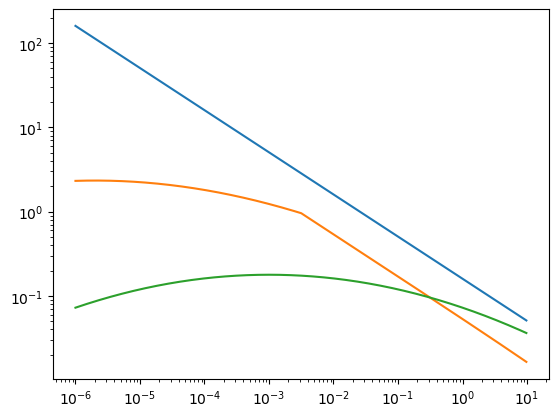

In [3]:
plt.loglog(lam_eval, pdf_eval)
plt.loglog(lam_eval, 1e-3*pdf)
plt.loglog(lam_eval, pdf_norm)


In [4]:
import scienceplots

plt.style.use(['science', 'no-latex', 'notebook', 'light'])

In [5]:
def f_BHOF(x, x0, delta=1, theta=2.5):
    # Occupation function 
    #return 1/2*(1 + np.tanh(2.5**np.abs(8.9 - x0) * (x - x0))) # (Miller 2015)
    return 1/(1 + delta * np.exp(-theta*(x - x0)))**(1/delta)

In [55]:
def log_likelihood(theta, x, y, xerr, yerr):

    # IT may not be worth it to do the gaussian convolutions if it works without them
    
    # parameters to be fit
    log_ms0, log_lam_min, delta1, log_f = theta

    mask_det = yerr > 0

    log_lam = y + 1 - 38.2 - (x - 4)
    lam = 10**loglam

    if log_lam_min > np.min(log_lam[mask_det]):
        return -np.inf

    log_lam_max = np.max(log_lam[mask_det])

    dlogl = .01 # .0001 doesnt help
    log_lam_eval = np.arange(log_lam_min, log_lam_max + dlogl, dlogl)
    lam_eval = 10**log_lam_eval
    dlam_eval = np.diff(lam_eval)

    log_lam_int = np.arange(log_lam_min - 4, log_lam_max + 4 + dlogl, dlogl)
    lam_int = 10**log_lam_int
    dlam_int = np.diff(lam_int)

    s2 = np.full(len(mask_det), np.exp(2*log_f)**2 + (xerr)**2)
    s2[mask_det] = yerr[mask_det]**2 + np.exp(2*log_f)**2 + (xerr[mask_det])**2

    # p = f * N + (1 - p) delta 
    _f_BHOF = f_BHOF(x, log_ms0)

    # Simulations indicate we need this Pareto -like thing
    delta1 = delta1 + 1
    
    # pdf
    lam_s = 1e2
    ep = 0

    pdf_pl_int = ( (lam_int/lam_s)**delta1 + (lam_int/lam_s)**(delta1+ep) )**(-1)
    pdf_int = fftconvolve(pdf_pl_int, st.norm.pdf(np.arange(-5, 5, .01), loc=0, scale=np.sqrt(np.mean(s2[mask_det]))), mode='same')
    # Trim
    f = interp1d(log_lam_int, pdf_int) #, bounds_error=False, fill_value=0.0)
    pdf_eval = f(log_lam_eval)
    # Normalize
    C = 1/trapezoid(pdf_eval, dx=dlam_eval)
    pdf_eval = C * pdf_eval
    f = interp1d(log_lam_eval, pdf_eval) #, bounds_error=False, fill_value=0.0)
    pdf = f(log_lam[mask_det])

    # Censored
    cdf_eval = cumulative_trapezoid(pdf_eval, dx=dlam_eval, initial=0)
    f = interp1d(log_lam_eval, cdf_eval, bounds_error=False, fill_value=(0.0, 1.0))
    cdf = f(log_lam[~mask_det])
    
    p_det = _f_BHOF[mask_det] * pdf # second term is zero for detected sources
    p_cens = _f_BHOF[~mask_det] * cdf + (1 - _f_BHOF[~mask_det])
    
    # Total likelihood
    ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))
    
    return ll

def log_likelihood_pl(theta, x, y, xerr, yerr):

    # IT may not be worth it to do the gaussian convolutions if it works without them
    
    # parameters to be fit
    log_ms0, log_lam_min, delta1, log_f = theta

    mask_det = yerr > 0

    log_lam = y + 1 - 38.2 - (x - 4)
    lam = 10**loglam

    if log_lam_min > np.min(log_lam[mask_det]):
        return -np.inf

    log_lam_max = np.max(log_lam)

    dlogl = .01 # .0001 doesnt help
    log_lam_eval = np.arange(log_lam_min, log_lam_max + dlogl, dlogl)
    lam_eval = 10**log_lam_eval
    dlam_eval = np.diff(lam_eval)

    s2 = np.full(len(mask_det), np.exp(2*log_f)**2 + (xerr)**2)
    s2[mask_det] = yerr[mask_det]**2 + np.exp(2*log_f)**2 + (xerr[mask_det])**2

    # p = f * N + (1 - p) delta 
    _f_BHOF = f_BHOF(x, log_ms0)

    # Simulations indicate we need this Pareto -like thing
    delta1 = delta1 + 1
    
    # pdf
    lam_s = 1e2
    ep = 0
    C = 1/trapezoid( ( (lam_eval/lam_s)**delta1 + (lam_eval/lam_s)**(delta1+ep) )**(-1), dx=dlam_eval)
    pdf = C * ( (lam[mask_det]/lam_s)**delta1 + (lam[mask_det]/lam_s)**(delta1+ep) )**(-1)

    # Censored
    pdf_eval = C * ( (lam_eval/lam_s)**delta1 + (lam_eval/lam_s)**(delta1+ep) )**(-1)
    cdf = cumulative_trapezoid(pdf_eval, dx=dlam_eval, initial=0)

    # Not that much faster, but more memory friendly
    f = interp1d(log_lam_eval, cdf, bounds_error=False, fill_value=(0.0, 1.0))
    cdf = f(log_lam[~mask_det])
    
    p_det = _f_BHOF[mask_det] * pdf # second term is zero for detected sources
    p_cens = _f_BHOF[~mask_det] * cdf + (1 - _f_BHOF[~mask_det])
    
    # Total likelihood
    ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))
    
    return ll

def log_likelihood_lognorm(theta, x, y, xerr, yerr, xp):
    
    # parameters to be fit
    log_ms0, alpha, beta, log_f = theta

    mask_det = yerr > 0

    # Total model variance
    s2 = np.exp(2*log_f)**2 + (beta*xerr)**2
    s2[mask_det] = yerr[mask_det]**2 + np.exp(2*log_f)**2 + (beta*xerr[mask_det])**2

    # This recovers the slope and scatter perfectly
    N = st.norm.pdf((y - alpha - beta*x), scale=np.sqrt(s2))
    S = st.norm.sf(-(y - alpha - beta*x), scale=np.sqrt(s2)) # This is what I would expect it to be

    # p = f * N + (1 - p) delta 

    _f_BHOF = f_BHOF(x + xp, log_ms0 + xp)
        
    p_det =  _f_BHOF[mask_det] * N[mask_det] # second term is zero for detected sources
    p_cens =  _f_BHOF[~mask_det] * S[~mask_det] + (1 - _f_BHOF[~mask_det])
    
    # Total likelihood
    ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))

    return ll

In [7]:
"""
# same exact data but different occupation
ds = []
ll = []
for di in np.arange(-1, 4, .05):
    theta = np.array([10, -10, di, 0])
    ds.append(di)
    ll.append(log_likelihood(theta, x, y, xerr, yerr))
plt.plot(ds, ll)
print(np.array(ds)[np.argmax(ll)])

ds = []
ll = []
for di in np.arange(-1, 4, .05):
    theta = np.array([3, -10, di, 0])
    ds.append(di)
    ll.append(log_likelihood(theta, x, y, xerr, yerr))
plt.plot(ds, ll)
print(np.array(ds)[np.argmax(ll)])
"""


'\n# same exact data but different occupation\nds = []\nll = []\nfor di in np.arange(-1, 4, .05):\n    theta = np.array([10, -10, di, 0])\n    ds.append(di)\n    ll.append(log_likelihood(theta, x, y, xerr, yerr))\nplt.plot(ds, ll)\nprint(np.array(ds)[np.argmax(ll)])\n\nds = []\nll = []\nfor di in np.arange(-1, 4, .05):\n    theta = np.array([3, -10, di, 0])\n    ds.append(di)\n    ll.append(log_likelihood(theta, x, y, xerr, yerr))\nplt.plot(ds, ll)\nprint(np.array(ds)[np.argmax(ll)])\n'

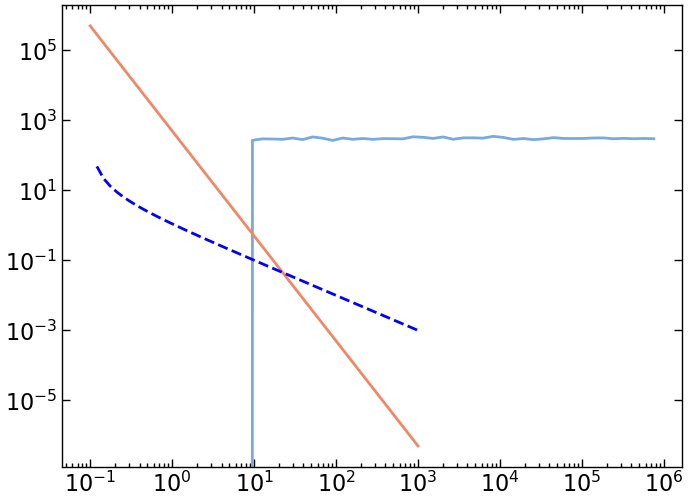

In [8]:
lam_min = 1e-10
delta1 = .0001

def pl_rvs(a, b, g, size=1):
    r = np.random.random(size=size)
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g)

plt.show()
h, b= np.histogram(pl_rvs(1e1, 1e9, -delta1, size=20000), bins=np.logspace(0, 6))
plt.loglog(b[:-1], h)

xx = np.logspace(-1, 3)
dxx = np.diff(xx)
plt.plot(xx, 500*xx**-3)

xx_conv = np.arange(-10, 10, 0.01)
dx = np.diff(xx_conv)

t = (delta1-1) * (1e-6)**(delta1-1) * (10**xx_conv)**-delta1
f = np.trapz( t * st.norm.pdf(np.log10(xx[:,np.newaxis]) - xx_conv, scale=np.sqrt(1)), dx=dx, axis=1)
plt.plot(xx, f, linestyle='dashed', color='k')

plt.plot(xx[1:], f[1:]/np.cumsum(np.interp(xx, xx, f)[1:]*dxx), linestyle='dashed', color='b')


#f = np.trapz(( ((10**np.arange(-10, 10, 0.1)/1e3)**delta1 + (10**np.arange(-10, 10, 0.1)/1e3)**(delta1+1))**-1) * st.norm.pdf(xx[:,np.newaxis] - np.arange(-10, 10, 0.1), scale=np.sqrt(50)), dx=.1, axis=1)
#plt.plot(xx, f, linestyle='dotted')

Something is wrong with the sampling -- 

In [19]:
import multiprocess as mp

os.environ["OMP_NUM_THREADS"] = "1"

#from multiprocessing import Pool
from multiprocess import Pool

from multiprocessing import cpu_count
ncpu = cpu_count() - 1
print("{0} CPUs".format(ncpu))

47 CPUs


min: -4.998663960492641


  4%|▍         | 25/600 [00:00<00:09, 59.69it/s]/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:60: RuntimeWarning: invalid value encountered in log
  ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))
  7%|▋         | 41/600 [00:00<00:08, 66.55it/s]/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:60: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))
100%|██████████| 600/600 [00:10<00:00, 58.74it/s]


(1280, 4)
95% CI:  6.871888753846857


/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/506461611.py:214: RuntimeWarning: invalid value encountered in divide
  frac_det = hist_det/hist_all


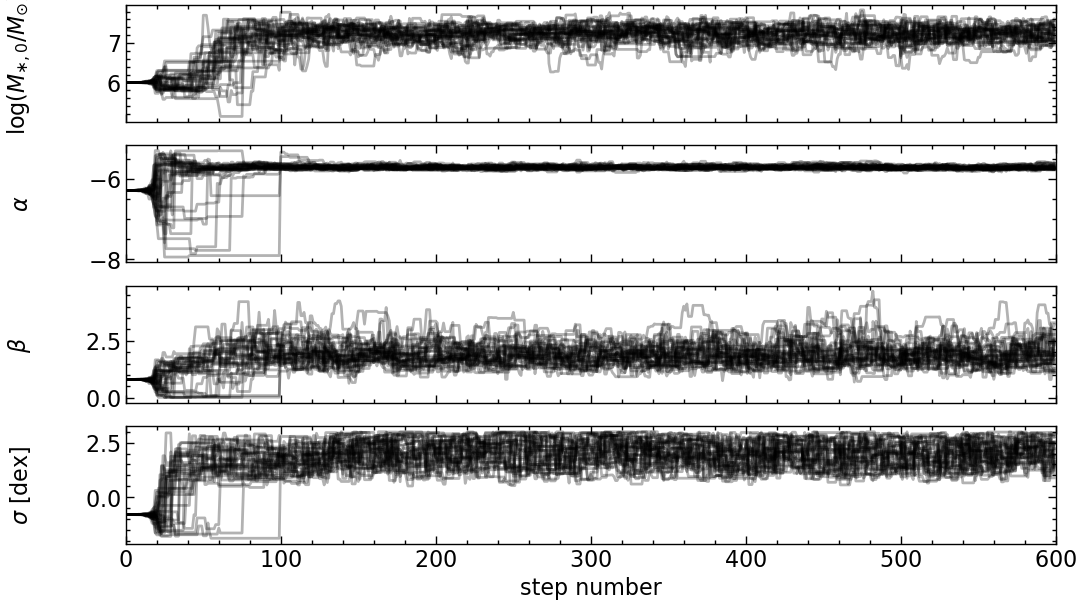

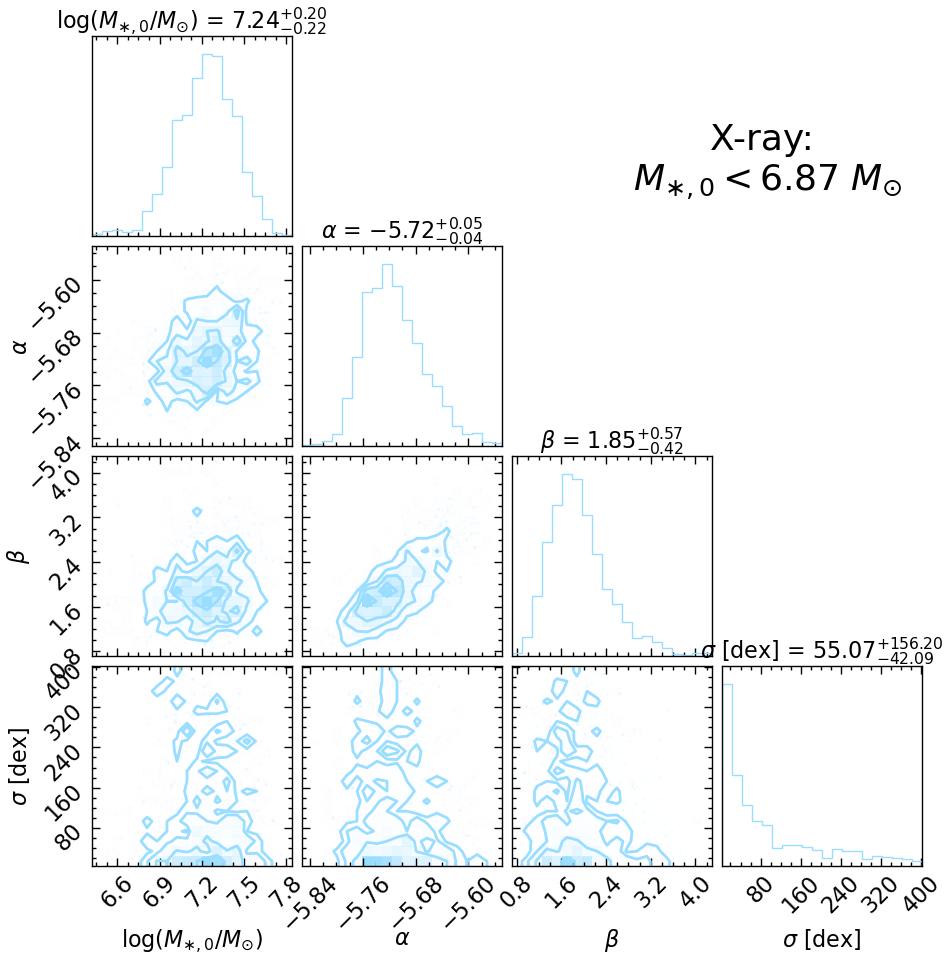

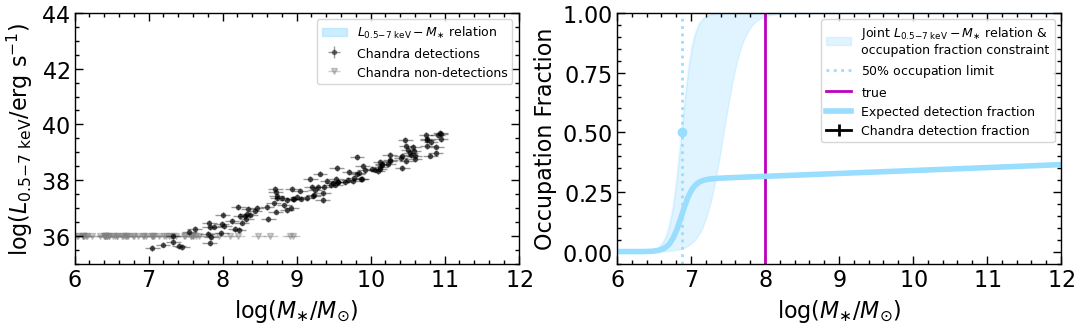

min: -4.999459040680518


  5%|▌         | 31/600 [00:00<00:09, 60.87it/s]/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:60: RuntimeWarning: invalid value encountered in log
  ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))
100%|██████████| 600/600 [00:09<00:00, 63.18it/s]


(1280, 4)
95% CI:  7.905125963975699


/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/506461611.py:214: RuntimeWarning: invalid value encountered in divide
  frac_det = hist_det/hist_all


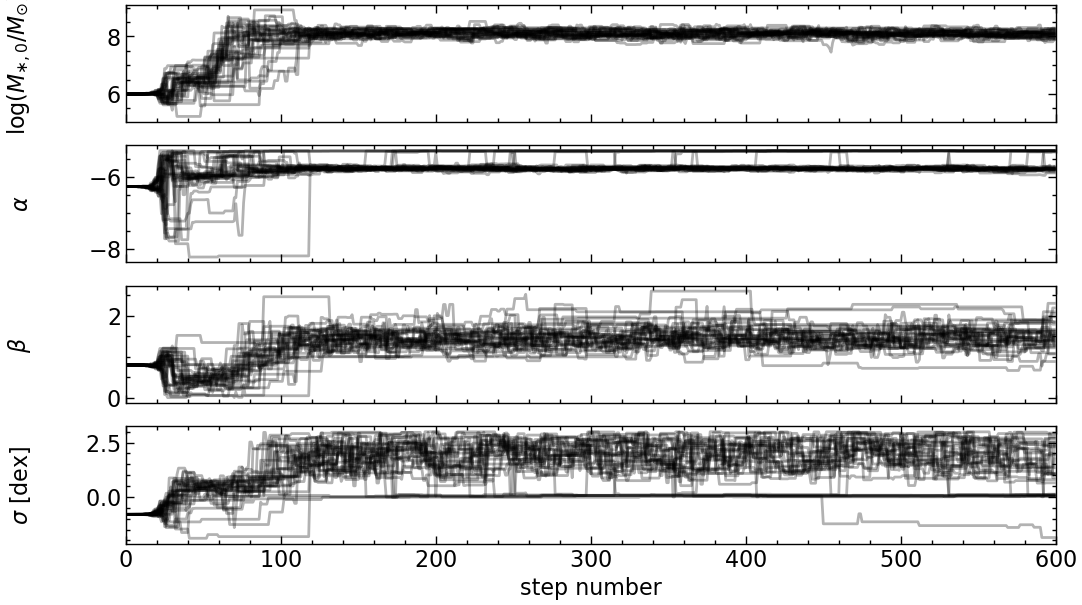

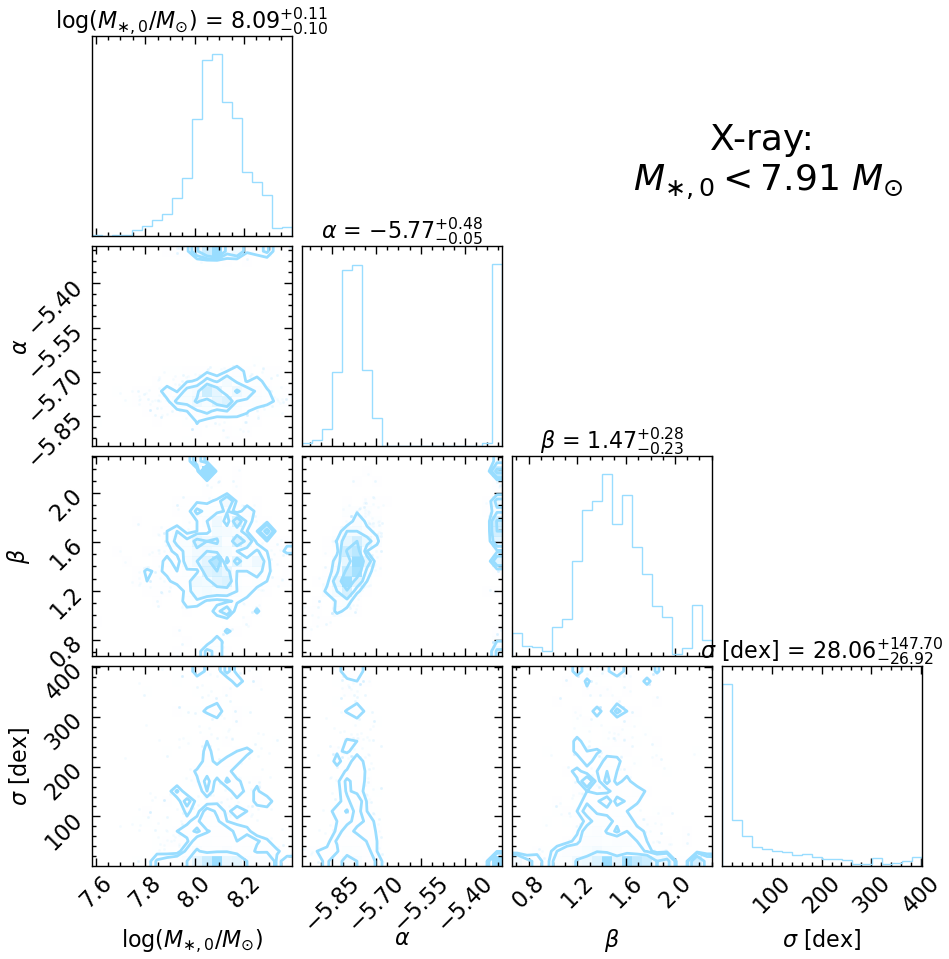

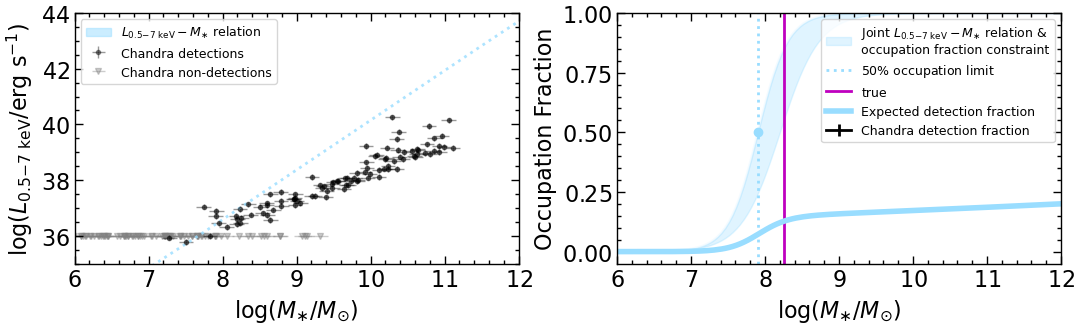

min: -4.999912214282351


  5%|▌         | 31/600 [00:00<00:09, 61.65it/s]/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:60: RuntimeWarning: invalid value encountered in log
  ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))
  8%|▊         | 45/600 [00:00<00:08, 63.51it/s]/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:60: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))
100%|██████████| 600/600 [00:10<00:00, 58.49it/s]


(1280, 4)
95% CI:  8.22465569103152


/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/506461611.py:214: RuntimeWarning: invalid value encountered in divide
  frac_det = hist_det/hist_all


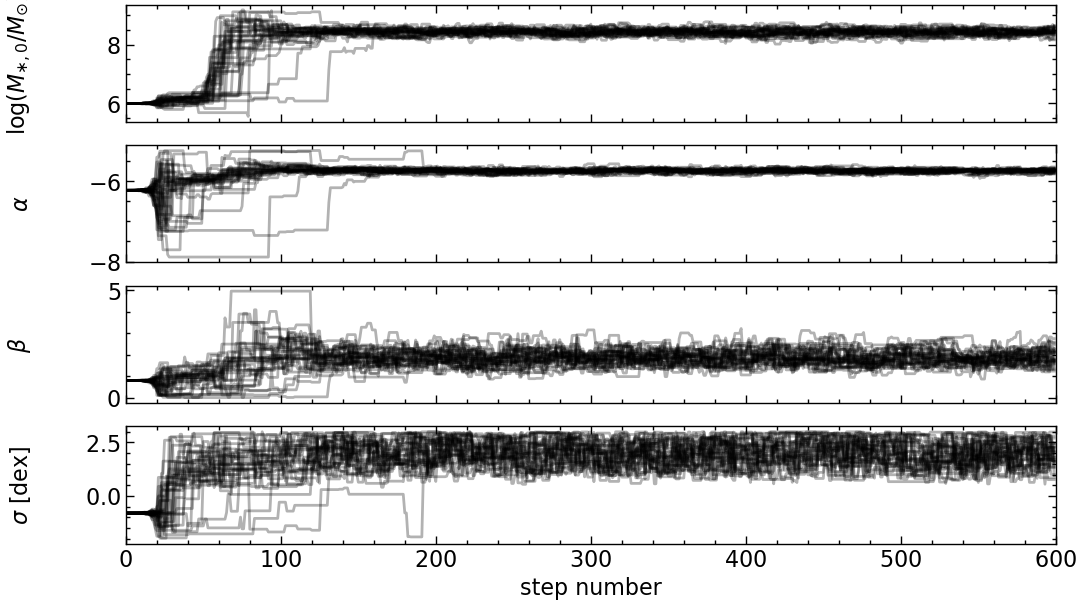

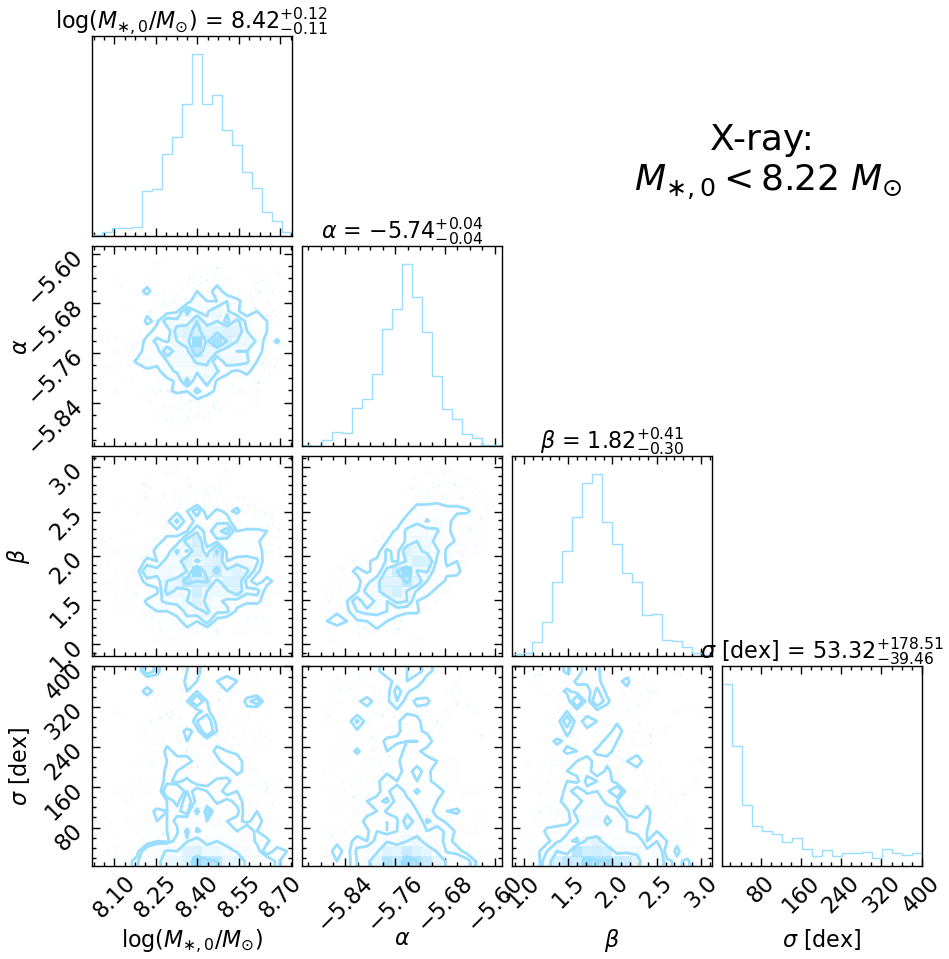

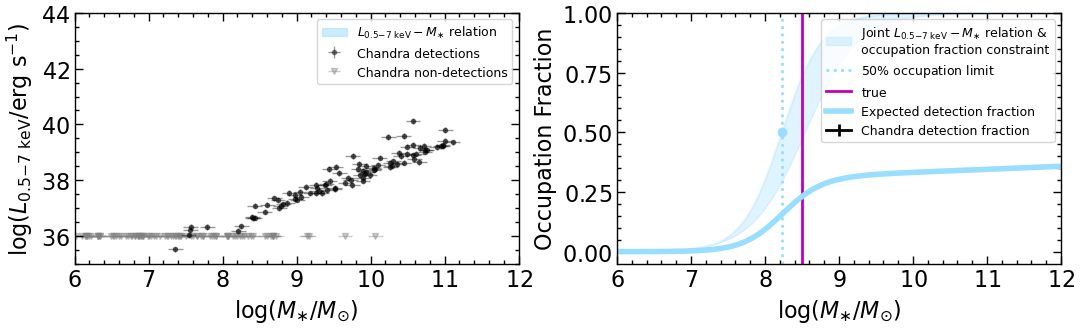

min: -4.992533197282359


  4%|▍         | 25/600 [00:00<00:09, 61.23it/s]/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:60: RuntimeWarning: invalid value encountered in log
  ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))
  5%|▌         | 32/600 [00:00<00:08, 63.16it/s]/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:60: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))
100%|██████████| 600/600 [00:09<00:00, 60.40it/s]


(1280, 4)
95% CI:  8.452539597440628


/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/506461611.py:214: RuntimeWarning: invalid value encountered in divide
  frac_det = hist_det/hist_all


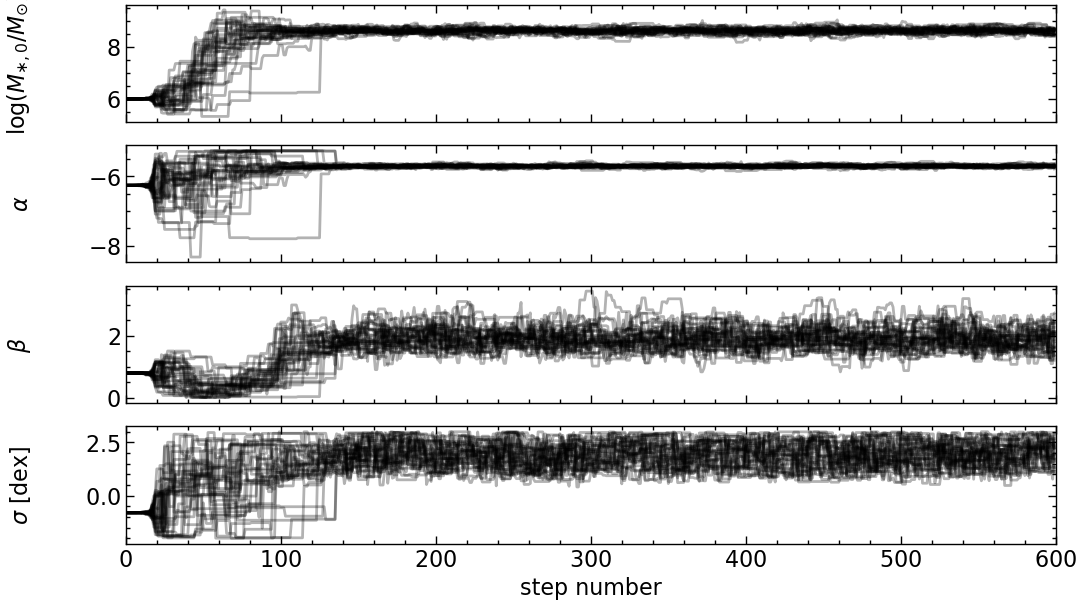

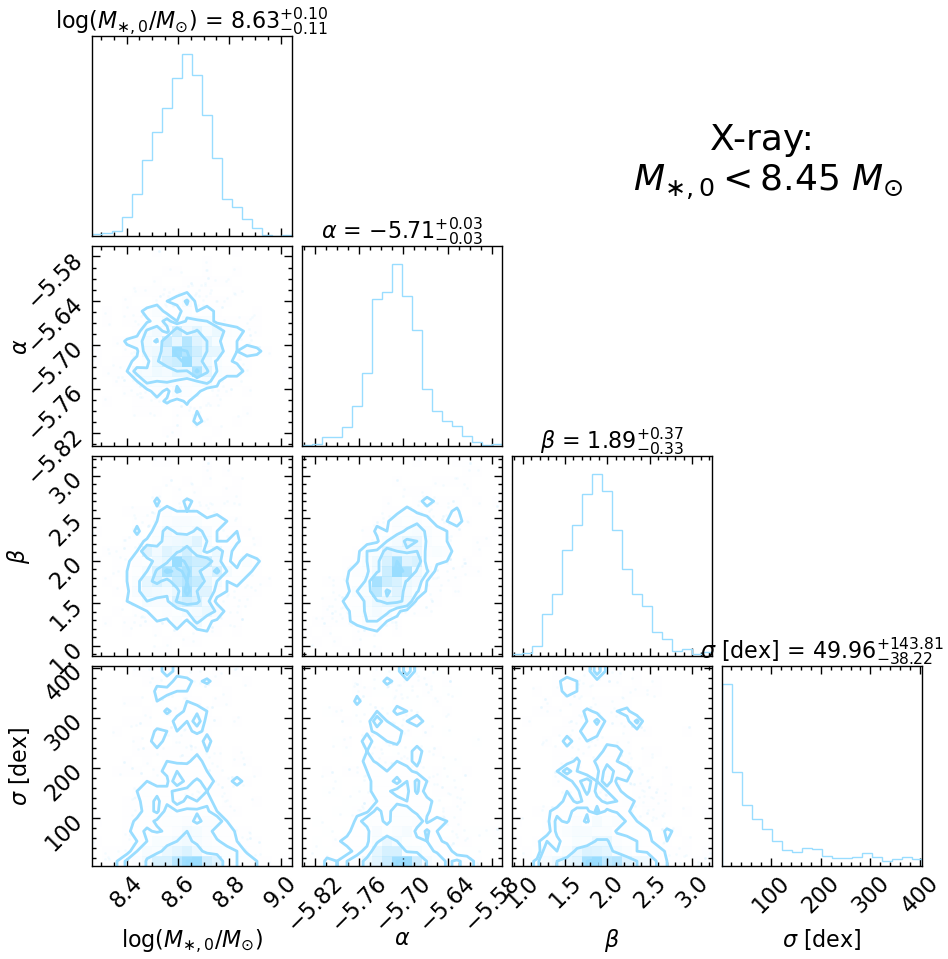

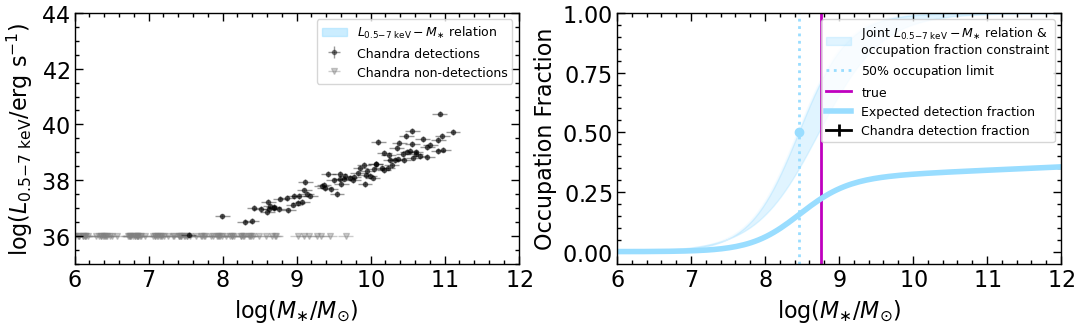

min: -4.999696391845812


  6%|▌         | 36/600 [00:00<00:09, 58.15it/s]/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:60: RuntimeWarning: invalid value encountered in log
  ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))
100%|██████████| 600/600 [00:10<00:00, 58.71it/s]


(1280, 4)
95% CI:  8.821248867577724


/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/506461611.py:214: RuntimeWarning: invalid value encountered in divide
  frac_det = hist_det/hist_all


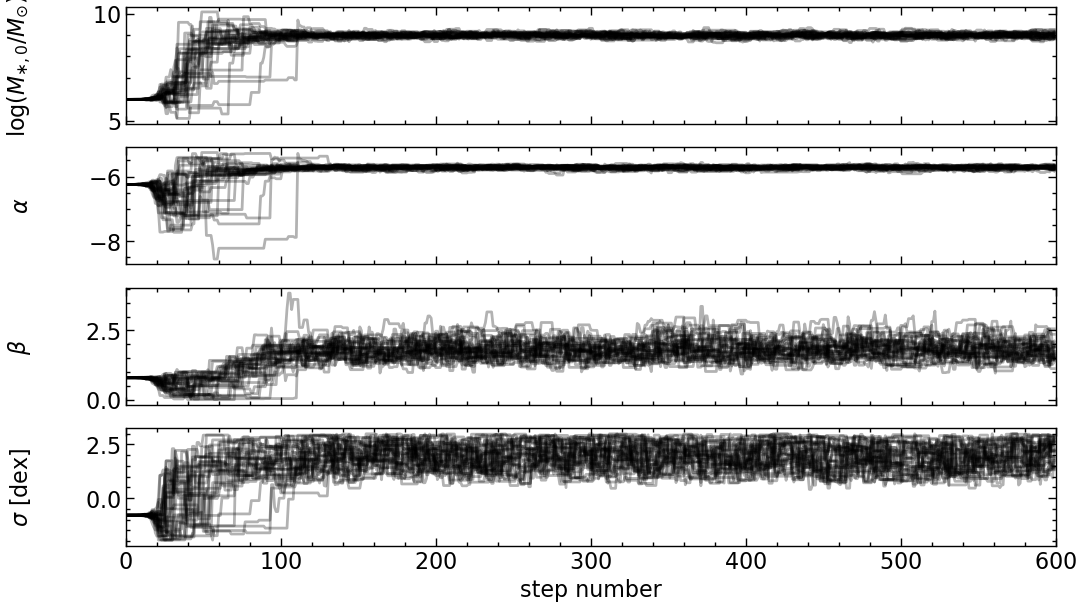

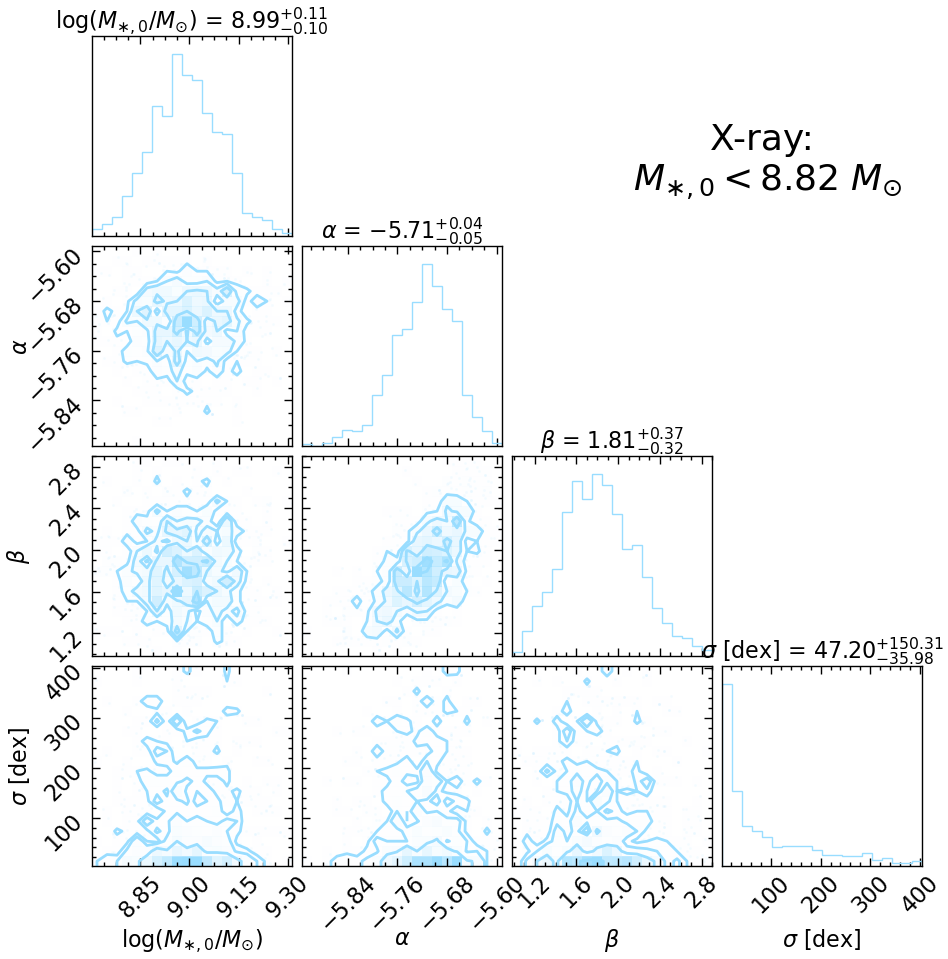

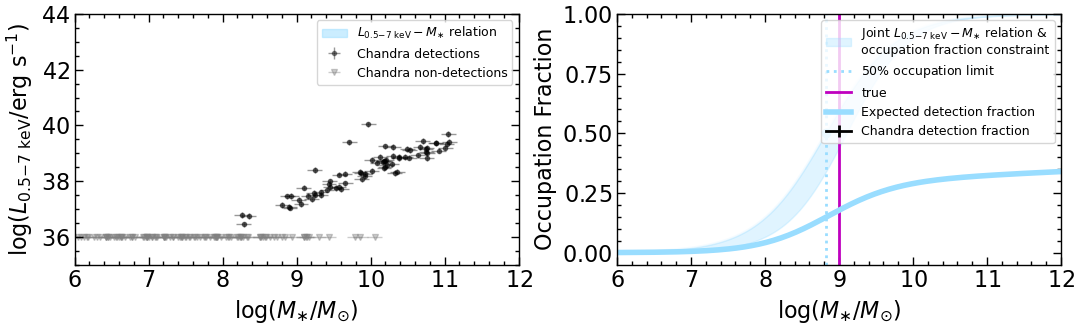

min: -4.999190552723487


  7%|▋         | 42/600 [00:00<00:09, 55.93it/s]/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:60: RuntimeWarning: invalid value encountered in log
  ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))
 19%|█▉        | 115/600 [00:01<00:07, 69.26it/s]/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:40: RuntimeWarning: overflow encountered in power
  pdf_pl_int = ( (lam_int/lam_s)**delta1 + (lam_int/lam_s)**(delta1+ep) )**(-1)
/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:40: RuntimeWarning: overflow encountered in add
  pdf_pl_int = ( (lam_int/lam_s)**delta1 + (lam_int/lam_s)**(delta1+ep) )**(-1)
 23%|██▎       | 136/600 [00:02<00:06, 66.35it/s]/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:40: RuntimeWarning: divide by zero encountered in reciprocal
  pdf_pl_int = ( (lam_int/lam_s)**delta1 + (lam_int/lam_s)**(delta1+ep) )**(-1)
/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:40: RuntimeWarning: overflow encountered in reciprocal
  pdf_pl_int = ( (lam_int/lam_s)*

(1280, 4)


/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/506461611.py:214: RuntimeWarning: invalid value encountered in divide
  frac_det = hist_det/hist_all


95% CI:  9.084130107473475


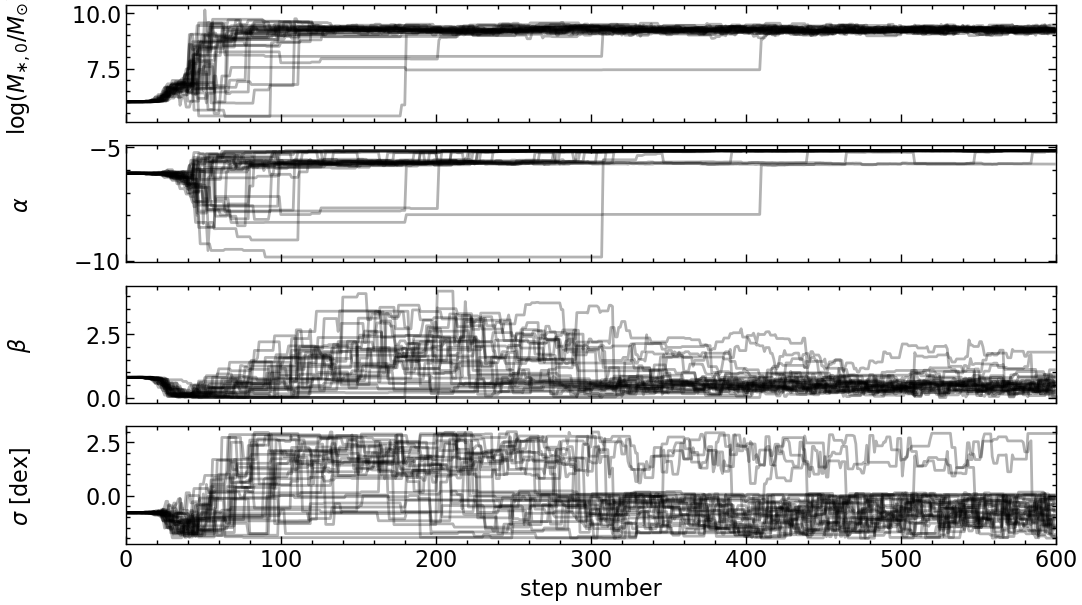

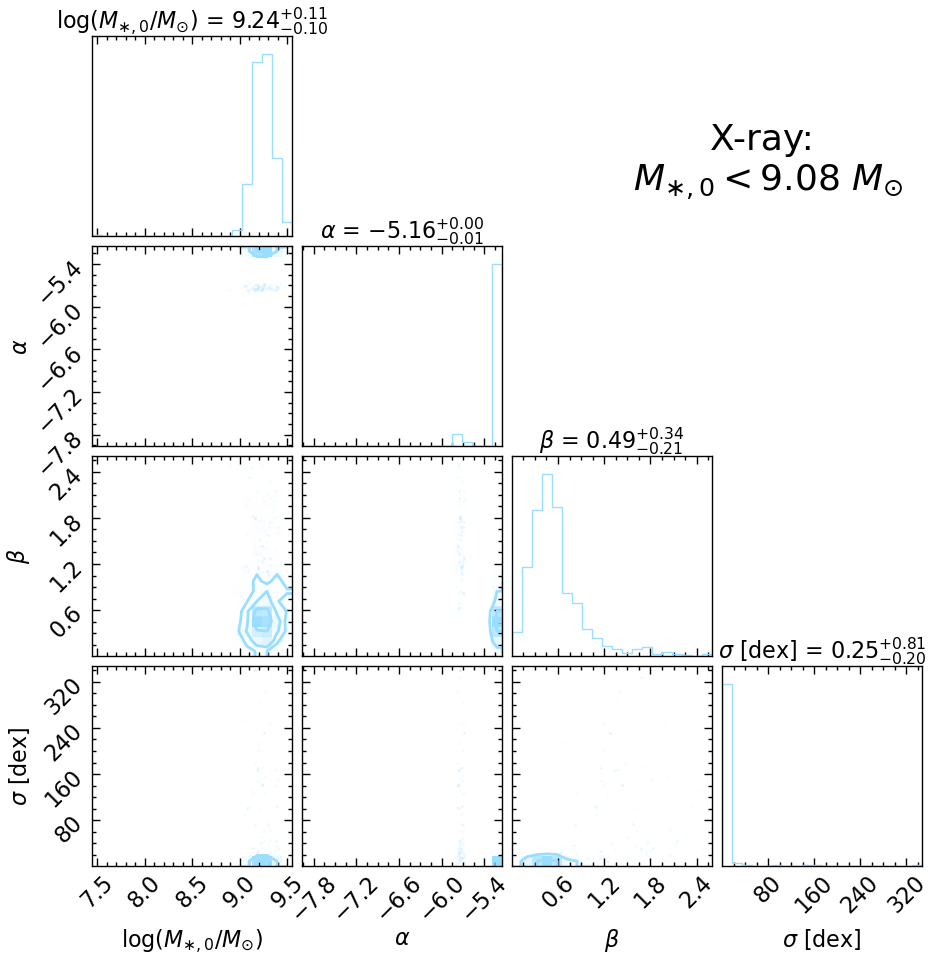

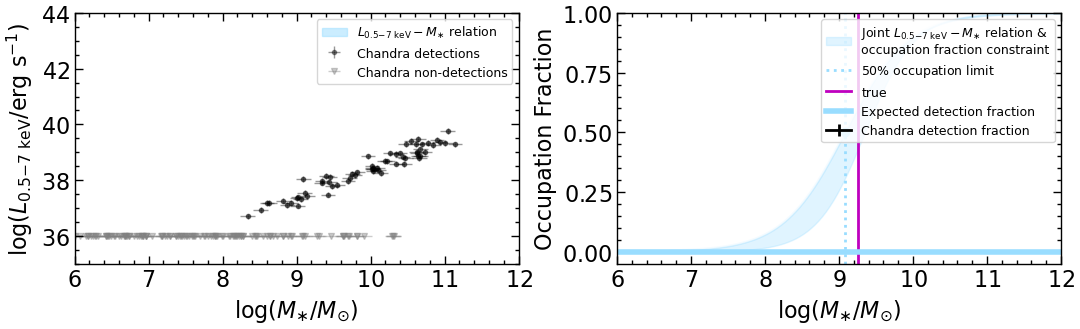

min: -4.9998075539639535


  6%|▌         | 36/600 [00:00<00:09, 56.49it/s]/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:60: RuntimeWarning: invalid value encountered in log
  ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))
 20%|█▉        | 119/600 [00:01<00:07, 67.52it/s]/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:60: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))
 32%|███▎      | 195/600 [00:02<00:05, 74.19it/s]/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:40: RuntimeWarning: overflow encountered in power
  pdf_pl_int = ( (lam_int/lam_s)**delta1 + (lam_int/lam_s)**(delta1+ep) )**(-1)
/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:40: RuntimeWarning: overflow encountered in add
  pdf_pl_int = ( (lam_int/lam_s)**delta1 + (lam_int/lam_s)**(delta1+ep) )**(-1)
100%|██████████| 600/600 [00:08<00:00, 71.09it/s]


(1280, 4)


/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/506461611.py:214: RuntimeWarning: invalid value encountered in divide
  frac_det = hist_det/hist_all


95% CI:  9.370719864680721


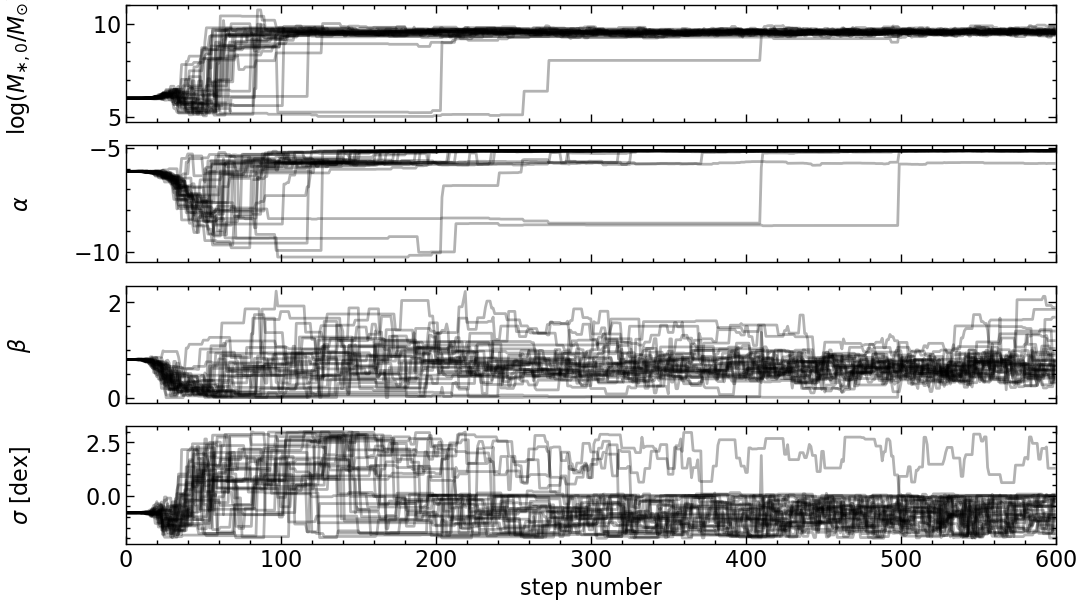

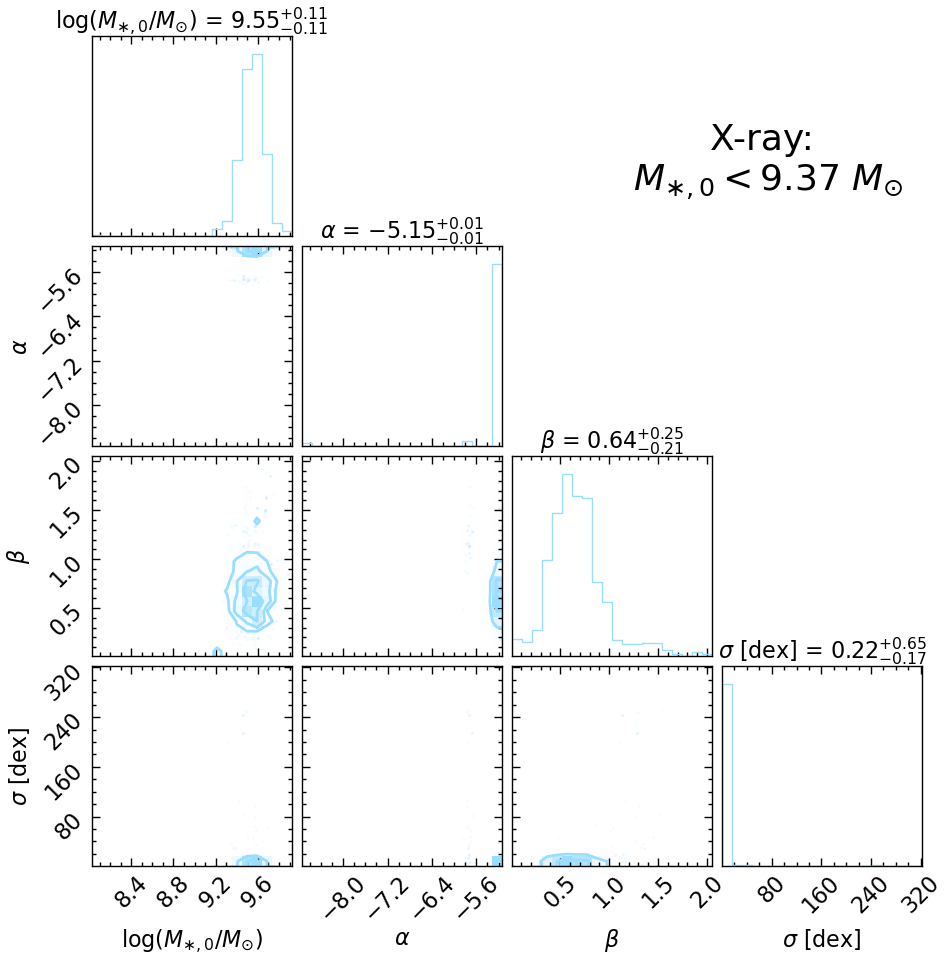

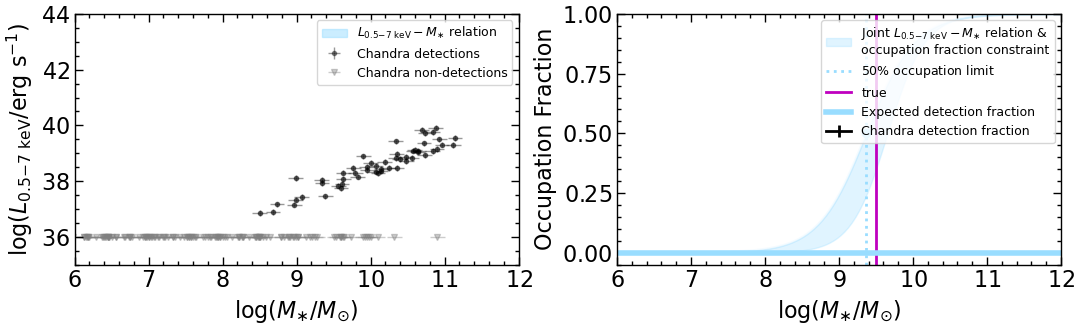

min: -4.999851307392264


  6%|▌         | 36/600 [00:00<00:10, 56.00it/s]/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:60: RuntimeWarning: invalid value encountered in log
  ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))
100%|██████████| 600/600 [00:08<00:00, 69.52it/s]


(1280, 4)


/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/506461611.py:214: RuntimeWarning: invalid value encountered in divide
  frac_det = hist_det/hist_all


95% CI:  9.623915363901254


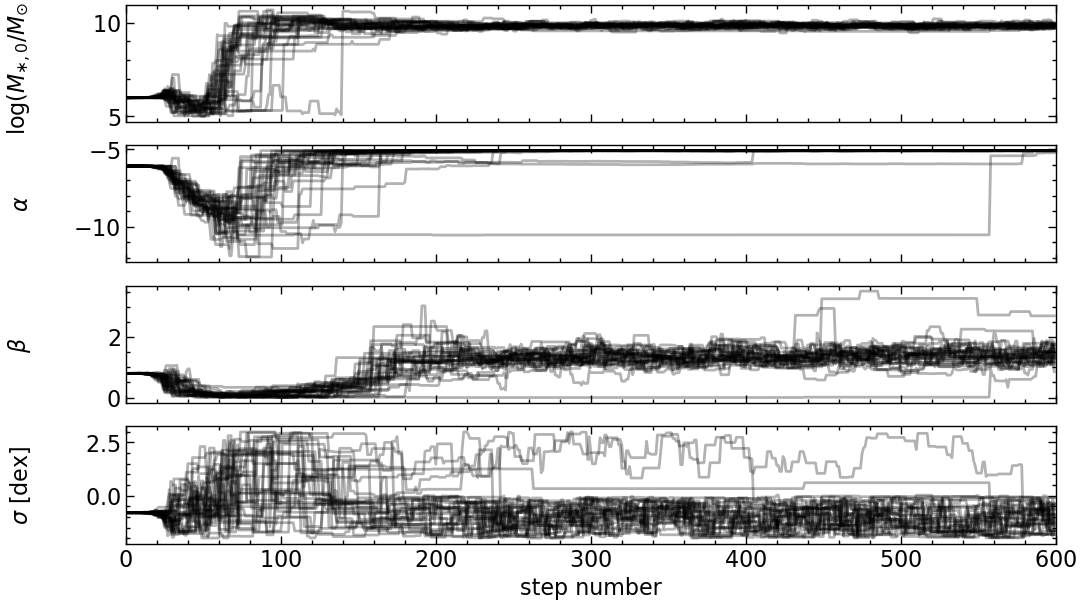

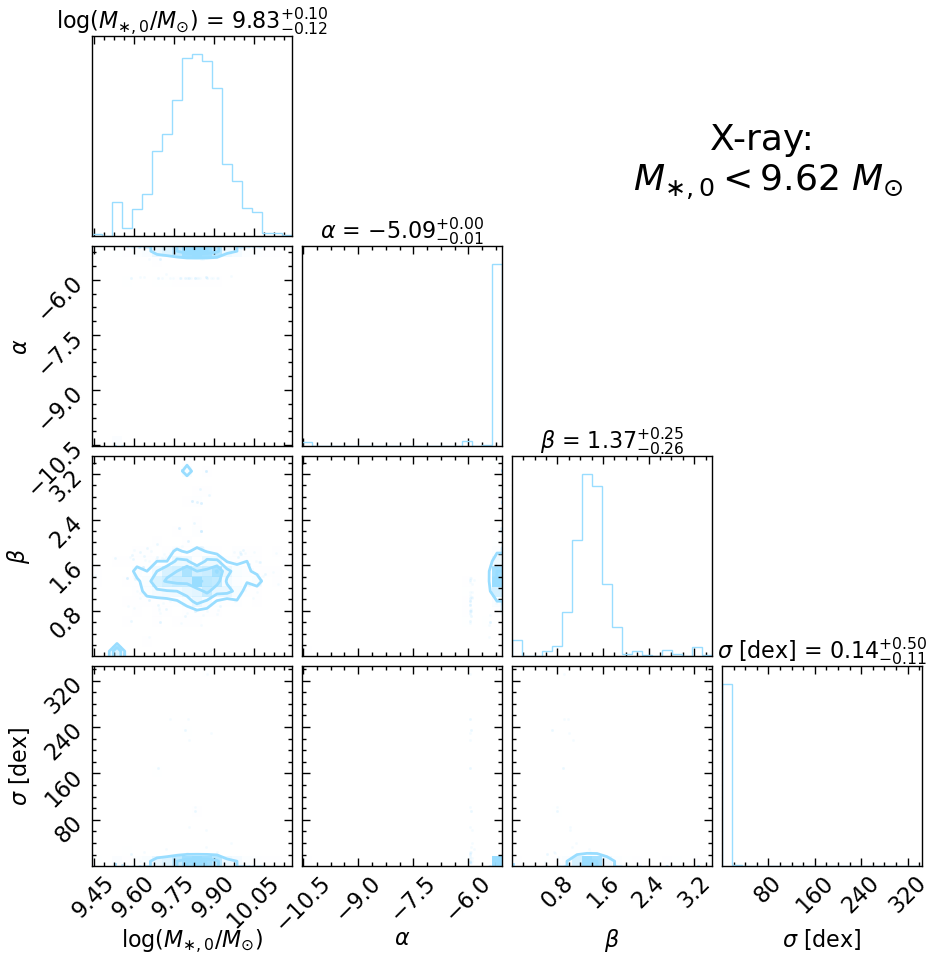

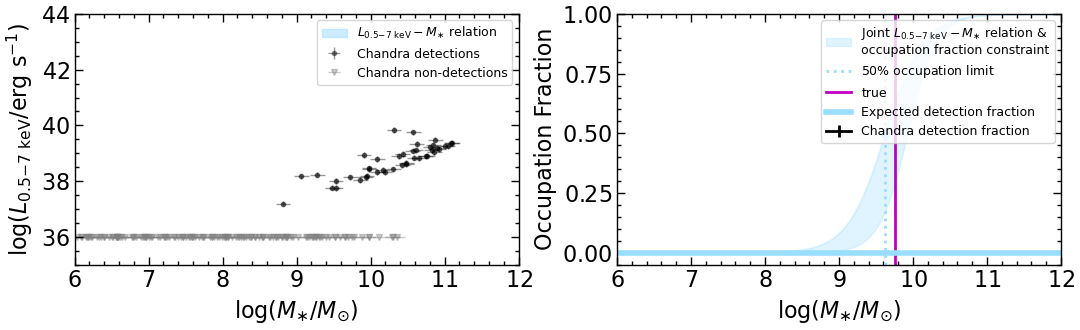

min: -4.998683914285178


  6%|▌         | 36/600 [00:00<00:09, 57.28it/s]/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:60: RuntimeWarning: invalid value encountered in log
  ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))
 82%|████████▏ | 494/600 [00:08<00:01, 67.59it/s]/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:60: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))
100%|██████████| 600/600 [00:09<00:00, 62.23it/s]


(1280, 4)


/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/506461611.py:214: RuntimeWarning: invalid value encountered in divide
  frac_det = hist_det/hist_all


95% CI:  9.820687562831349


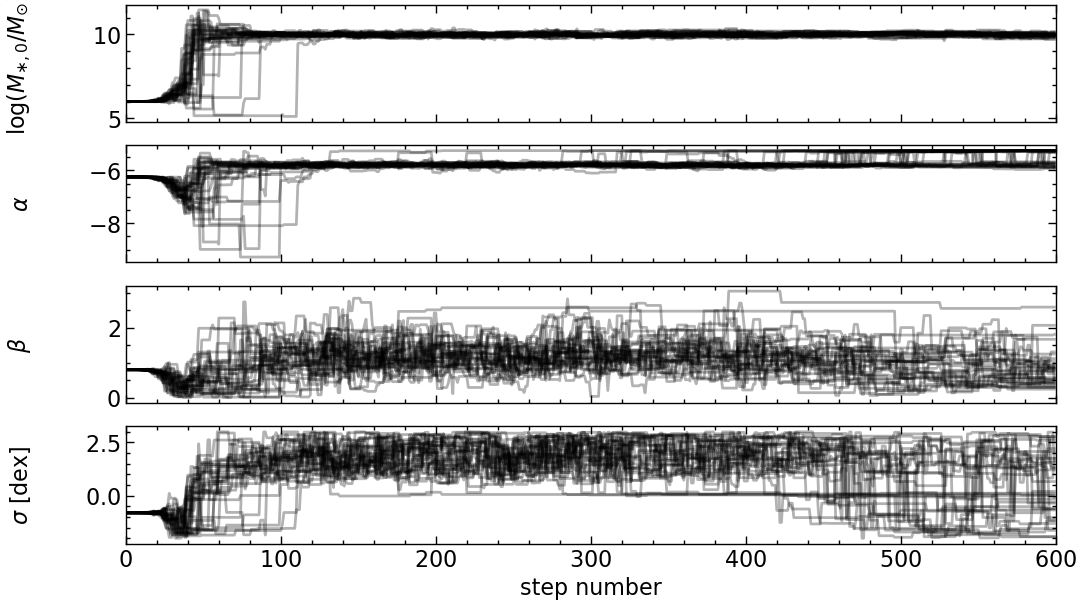

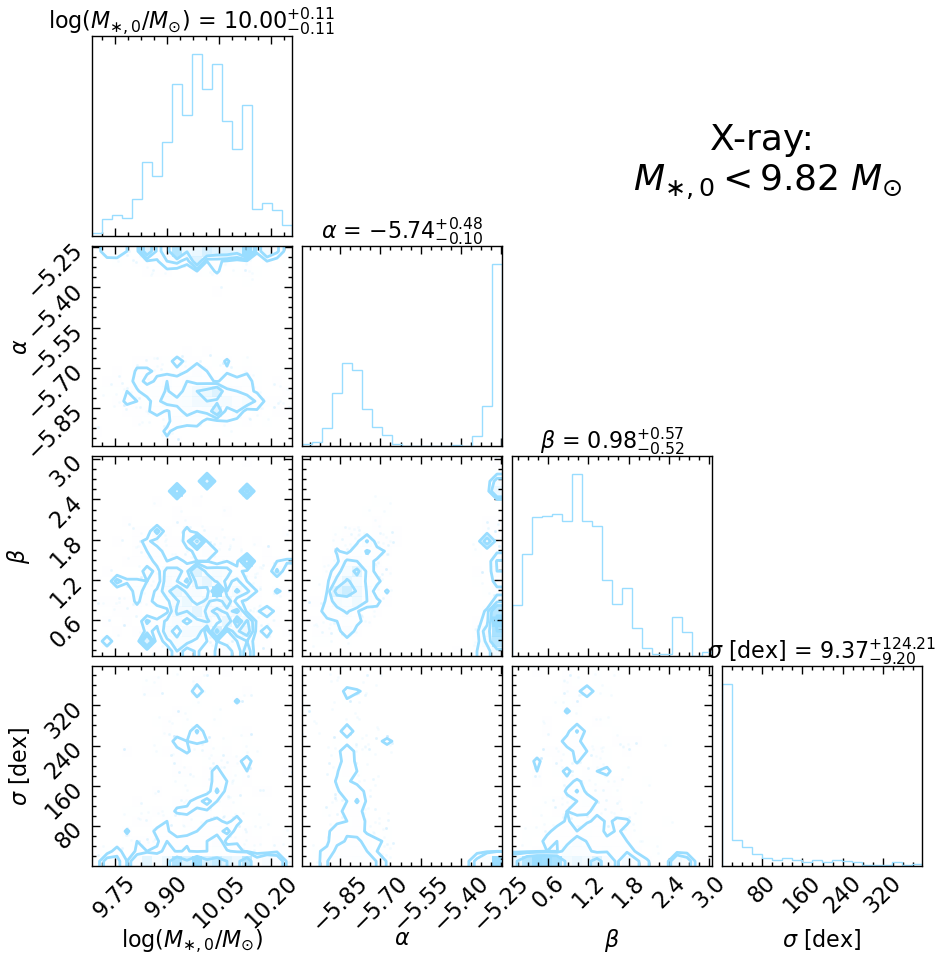

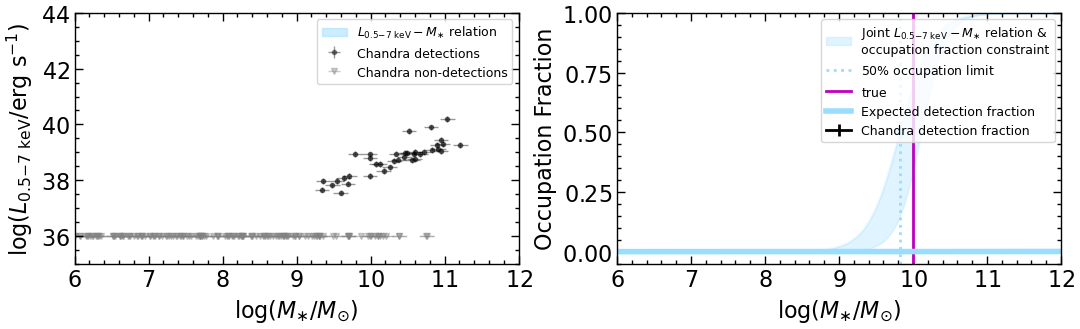

min: -4.998548138209157


  5%|▌         | 30/600 [00:00<00:09, 57.15it/s]/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:60: RuntimeWarning: invalid value encountered in log
  ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))
/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:60: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))
 12%|█▏        | 71/600 [00:01<00:08, 66.08it/s]/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:40: RuntimeWarning: overflow encountered in power
  pdf_pl_int = ( (lam_int/lam_s)**delta1 + (lam_int/lam_s)**(delta1+ep) )**(-1)
/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:40: RuntimeWarning: overflow encountered in add
  pdf_pl_int = ( (lam_int/lam_s)**delta1 + (lam_int/lam_s)**(delta1+ep) )**(-1)
 20%|██        | 123/600 [00:01<00:06, 69.58it/s]/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/2124623767.py:40: RuntimeWarning: overflow encountered in reciprocal
  pdf_pl_int = ( (lam_int/lam_s)**delta1 + (lam_int/lam_s)**(delta1

(1280, 4)


/tmp/tmp.vO9VsTdE8J/ipykernel_3649886/506461611.py:214: RuntimeWarning: invalid value encountered in divide
  frac_det = hist_det/hist_all


95% CI:  10.234493509653813


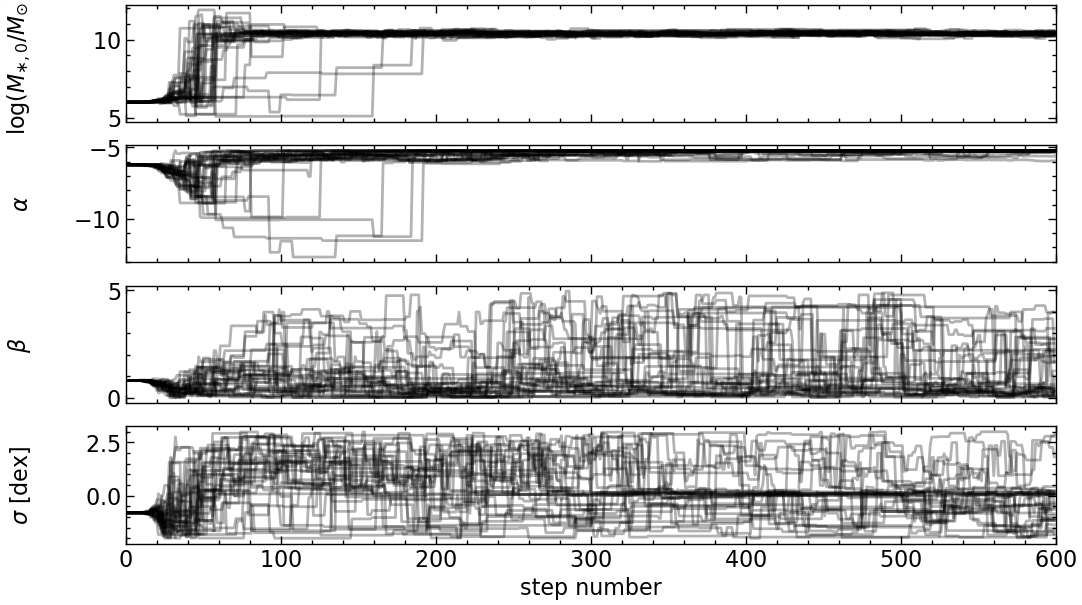

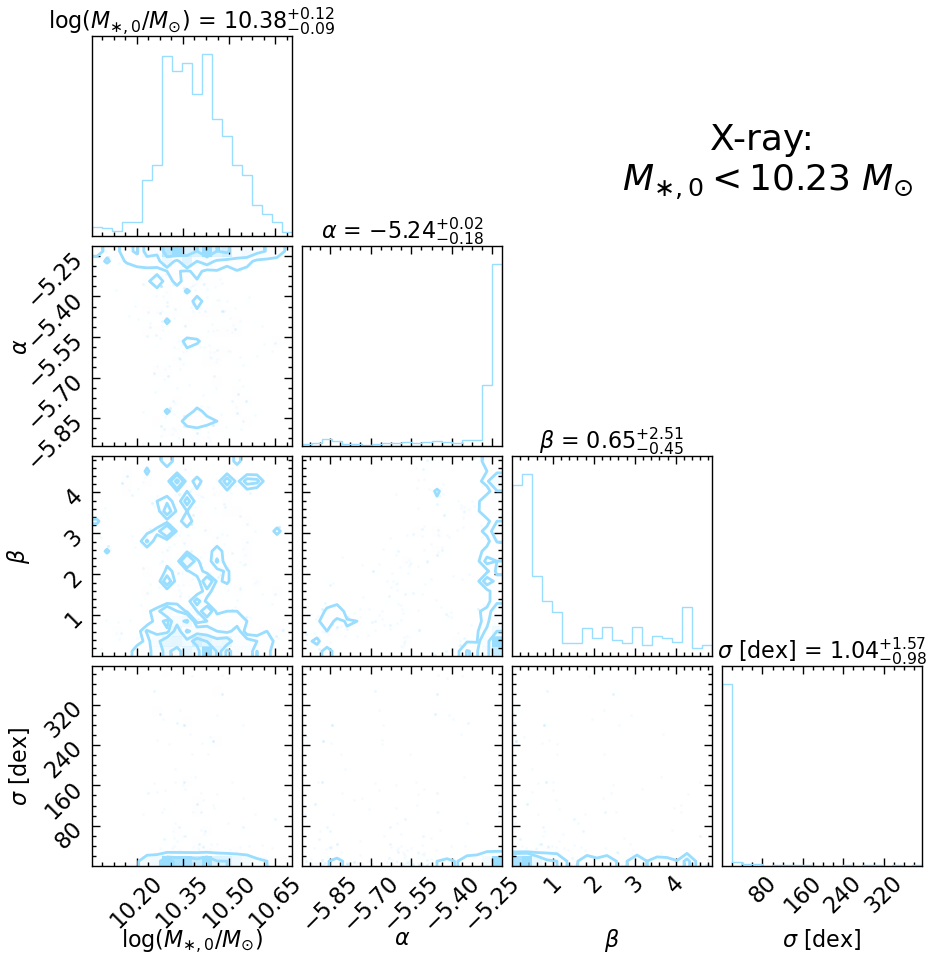

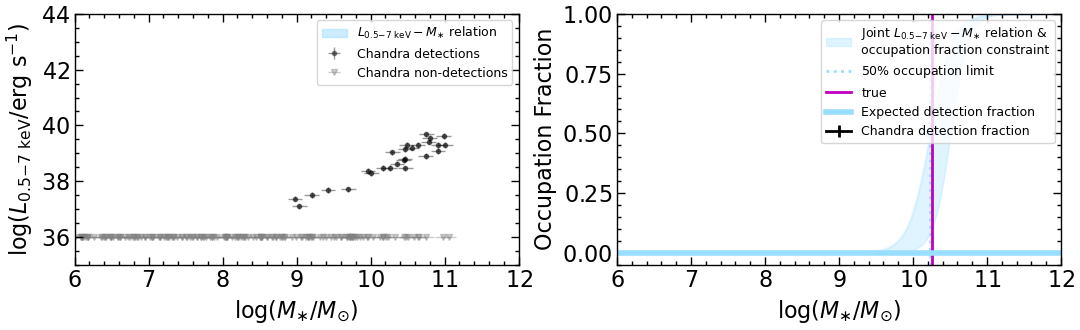

In [57]:
x50_out_lo = []
x50_out_med =[]
x50_out_hi = []

beta_out_lo = []
beta_out_med =[]
beta_out_hi = []

#x50_true = np.arange(6, 10.5, .25) # Input
x50_true = np.arange(8, 10.5, .25) # Input

delta1_true = 1.8

for i, log_x50_i in enumerate(x50_true): 

    # Draw from p(y | x)
    x = np.linspace(6, 11, 200)

    y = x - 4 + 38.2 - 1

    np.random.seed(42 + i)

    loglam = np.log10(1e5 * pl_rvs(1e-10, 1, -delta1_true, size=len(x)))
    
    y = y + loglam

    print('min:', np.min(loglam))

    #y = y + np.random.normal(0.0, .8, size=len(x))
    
    # uncertainties
    xerr = np.full(len(x), 0.1)
    yerr = np.full(len(x), 0.1)

    # I_occ = 1 means BH is there
    # I_occ = 0 means no BH
    I_occ = st.bernoulli.rvs(f_BHOF(x, log_x50_i), size=len(x))
    #I_occ = st.bernoulli.rvs(1, size=len(x))

    # Mimic
    x += np.random.normal(0, xerr)
    y += np.random.normal(0, yerr)

    y[I_occ==0] = -9999

    ## Randomly add some high limits
    y[::10] = 50.
    yerr[::10] = -1.0

    # limiting sensitivity
    y_lim = 35.5 #38.5

    # Negative error means upper-limit
    mask_lim = y < y_lim #
    yerr[mask_lim] = -1.0
    y[mask_lim] = y_lim + 5*0.1 # 3\sigma

    ######### ignore below, just running emcee #########

    nsamp=600
    nburn=400
    color='C4'

    np.random.seed(42)

    log_lam = y + 1 - 38.2 - (x - 4)
    pos = [6, np.min(log_lam[yerr > 0])-1, .8, -0.8] 
    pos = np.array(pos) + 1e-4 * np.random.randn(32, len(pos))
    # Don't jitter log_lam
    #pos[:,1] = np.min(log_lam[yerr > 0])

    nwalkers, ndim = pos.shape

    # Prob
    def log_prior(theta, log_lam, yerr):
        logms0, log_lam_min, beta, log_f = theta
        if 5.0 < logms0 < 12.0 and -20 <= log_lam_min <= np.min(log_lam[yerr > 0]) and 0.0 < beta < 5.0 and -2.0 < log_f < 3.0:
            return 0.0
        return -np.inf

    args_global = (x, y, xerr, yerr)
    def log_probability(theta):
        x, y, xerr, yerr = args_global
        log_lam = y + 1 - 38.2 - (x - 4)
        lp = log_prior(theta, log_lam, yerr)
        ll = log_likelihood(theta, x, y, xerr, yerr)
        if not np.isfinite(lp) or not np.isfinite(ll):
            return -np.inf
        return lp + ll

    # Sampler
    ncpu = 1

    # Sampler
    if ncpu > 1:
        with mp.Pool(ncpu) as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool=pool, moves=[
            (emcee.moves.DEMove(), 0.8),
            (emcee.moves.DESnookerMove(), 0.2),
            ],)
            sampler.run_mcmc(pos, nsamp, progress=True);
    else:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, moves=[
            (emcee.moves.DEMove(), 0.8),
            (emcee.moves.DESnookerMove(), 0.2),
        ],)
        sampler.run_mcmc(pos, nsamp, progress=True);

    # Plot (you can ignore this)

    fig, axes = plt.subplots(ndim, figsize=(12, 7), sharex=True)
    samples = sampler.get_chain()

    labels = [r"$\log(M_{\ast,0}/M_{\odot})$", r"$\alpha$", r"$\beta$", r"$\sigma$ [dex]"]

    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");

    #tau = sampler.get_autocorr_time()
    #print(tau)
    # I'm probably not running long enough chain, yeah yeah...

    flat_samples = sampler.get_chain(discard=nburn, thin=5, flat=True)
    print(flat_samples.shape)

    # Medians
    alpha_x50 = np.median(flat_samples[:,1])
    beta_x50 = np.median(flat_samples[:,2])
    sigma50 = np.median(np.exp(2*flat_samples[:,3])) 

    # Corner
    flat_samples[:,3] = np.exp(2*flat_samples[:,3]) #### sigma
    fig_corner = corner.corner(flat_samples, labels=labels, color=color, show_titles=True)

    # TODO::::: Increase the 1st column limit + 1 and use 95th percentile

    fig, axes = plt.subplots(1, 2, figsize=(11, 3.5))

    # Plot data
    x_eval = np.linspace(5, 15, 200)
    axes[0].scatter(x[yerr > 0], y[yerr > 0], marker='.', color='k', alpha=0.2)
    axes[0].errorbar(x[yerr > 0], y[yerr > 0], elinewidth=1,
                        xerr=xerr[yerr > 0], yerr=yerr[yerr > 0],
                        fmt=".k", capsize=0, alpha=0.4, label='Chandra detections')
    # Pick random
    if len(x[yerr < 0]) > 50000:
        ind_rand = np.random.choice(len(x[yerr < 0]), 50, replace=False)
    else:
        ind_rand = np.arange(len(x[yerr < 0]))
    axes[0].errorbar(x[yerr < 0][ind_rand], y[yerr < 0][ind_rand],
                        xerr=xerr[yerr < 0][ind_rand], elinewidth=1, markersize=5,
                        marker="v", linestyle="none", color="gray", alpha=0.4, capsize=0, zorder=-1, label='Chandra non-detections')


    axes[0].legend(fontsize=14)
    axes[0].set_xlim([6, 12])
    axes[0].set_ylim([35, 44])
    axes[0].set_xlabel(r'$\log(M_{\ast} / M_{\odot})$')
    axes[0].set_ylabel(r'$\log(L_{0.5{-}7\ {\rm{keV}}} / {\rm{erg}}\ {\rm{s}}^{-1})$')

    # Linear relation
    relation = np.zeros([len(flat_samples), len(x_eval)])
    for i, s in enumerate(flat_samples):
        relation[i,:] = np.dot(np.vander(x_eval, 2), [s[2], s[1]])

    axes[0].fill_between(x_eval, np.percentile(relation, 84, axis=0), np.percentile(relation, 16, axis=0),
                            color=color, alpha=0.5, zorder=2, label=r'$L_{0.5{-}7\ {\rm{keV}}} - M_{\ast}$ relation')
    axes[0].plot(x_eval, np.percentile(relation, 84, axis=0)+sigma50,
                color=color, alpha=0.8, zorder=2, linestyle='dotted')
    axes[0].plot(x_eval, np.percentile(relation, 16, axis=0)-sigma50,
                color=color, alpha=0.8, zorder=2, linestyle='dotted')

    # Limits
    #mask_outlier = flat_samples[:,0] > np.percentile(flat_samples[:,0], 50)

    log_ms50_low = np.percentile(flat_samples[:,0], 5)
    log_ms50_med = np.percentile(flat_samples[:,0], 95)
    log_ms50_high = np.percentile(flat_samples[:,0], 84)
    print('95% CI: ', log_ms50_low)

    x50_out_lo.append(log_ms50_low)
    x50_out_med.append(log_ms50_med)
    x50_out_hi.append(log_ms50_high)

    # Occupation fraction
    alpha50 = np.median(flat_samples[:,1])
    beta50 = np.median(flat_samples[:,2])
    f_occ_low = 1/2*(1 + np.tanh(2.5**np.abs(8.9 - log_ms50_low) * (x_eval - log_ms50_low)))
    f_occ_high = 1/2*(1 + np.tanh(2.5**np.abs(8.9 - log_ms50_high) * (x_eval - log_ms50_high)))
        
    beta_out_lo.append(np.percentile(flat_samples[:,2], 95))
    beta_out_med.append(np.percentile(flat_samples[:,2], 55))
    beta_out_hi.append(np.percentile(flat_samples[:,2], 5))

    axes[1].plot(x_eval, f_occ_low, color, alpha=0.1)
    axes[1].fill_between(x_eval, f_occ_high,  f_occ_low, color=color, alpha=0.3,
                            label=r'Joint $L_{0.5{-}7\ {\rm{keV}}} - M_{\ast}$ relation &'+'\n'+'occupation fraction constraint')

    # 50% occupation
    axes[1].scatter(log_ms50_low, 0.5, color=color)
    axes[1].axvline(log_ms50_low, linestyle='dotted', color=color, label=r'$50\%$ occupation limit')
        
    axes[1].axvline(log_x50_i, color='m', label=r'true')

    # Histogram
    hist_det, bin_edges = np.histogram(x[yerr>0], bins=np.arange(-3, 3, 0.5))
    hist_all, bin_edges = np.histogram(x,  bins=np.arange(-3, 3, 0.5))
    frac_det = hist_det/hist_all

    bincenter = (bin_edges[:-1] + bin_edges[1:]) / 2

    axes[1].errorbar(bincenter[hist_det>0], frac_det[hist_det>0],
                        yerr=st.binom.std(hist_all[hist_det>0], frac_det[hist_det>0])/hist_all[hist_det>0],
                        color="k", capsize=0, label='Chandra detection fraction')


    axes[1].plot(x_eval, f_occ_low * st.norm.sf(y_lim, alpha50 + beta50*(x_eval), sigma50),
                color=color, lw=4, label=r'Expected detection fraction')

    axes[1].set_xlim([6, 12])
    axes[1].set_ylim([None, 1])
    axes[1].set_xlabel(r"$\log(M_{\ast} / M_{\odot})$")
    axes[1].set_ylabel(r"Occupation Fraction")

    axes[0].legend(loc=0, fontsize=9, frameon=True)
    axes[1].legend(loc=1, fontsize=9, frameon=True)

    fig_corner.text(.8, .8, 'X-ray: \n'+r'$M_{\ast,0} < $'+f'{np.round(log_ms50_low,2)}'+r' $M_{\odot}$', ha='center', fontsize=26)

    fig.tight_layout()
    plt.show()

x50_out_med = np.array(x50_out_med)
x50_out_lo = np.array(x50_out_lo)
x50_out_hi = np.array(x50_out_hi)

beta_out_med = np.array(beta_out_med)
beta_out_lo = np.array(beta_out_lo)
beta_out_hi = np.array(beta_out_hi)

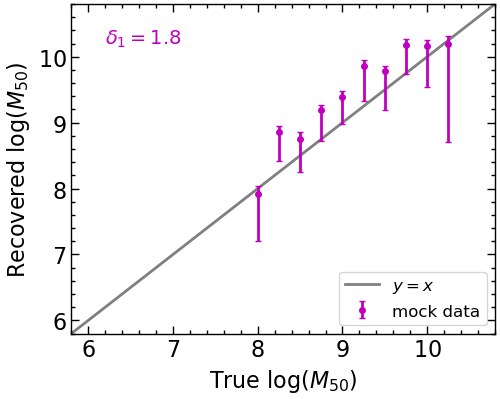

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5.2, 4.2))

ax.plot([5, 11], [5, 11], lw=2, color='gray', zorder=-10, label=r'$y=x$')

#ax.axhline(y_lim - (- 4 + 38.2 - 1) + 4, color='gray', linestyle='dotted', label=r'$y=y_{\rm{lim}}$')

asymm = np.mean([(x50_out_med-x50_out_lo), (x50_out_hi-x50_out_med)], axis=0)/x50_out_med
mask = asymm > 1

ax.errorbar(x50_true[~mask], x50_out_med[~mask], yerr=np.abs(np.array([x50_out_med-x50_out_lo, x50_out_hi-x50_out_med]))[:,~mask],
           color='m', marker='o', capsize=2.5, linestyle='none', markersize=4, label='mock data')

u = np.full_like(x50_out_lo, 0.0)
ax.errorbar(x50_true[mask], x50_out_med[mask], yerr=np.abs(np.array([u, x50_out_hi-x50_out_med]))[:,mask],
           color='m', marker='v', capsize=2, linestyle='none', markersize=10)

# If the distribution is not well constrained, use upper limit


#ax.scatter(x50_true, x50_out_med, color='k')

ax.set_ylabel(r'Recovered $\log(M_{50})$')
ax.set_xlabel(r'True $\log(M_{50})$')

ax.text(6.2, 10.2, rf'$\delta_1 = {delta1_true}$', fontsize=14, color='m')


ax.set_xlim(5.8, 10.8)
ax.set_ylim(5.8, 10.8)

ax.legend(loc=4, fontsize=12, frameon=True)

fig.tight_layout()
fig.savefig('BHOFmock.pdf', dpi=300)

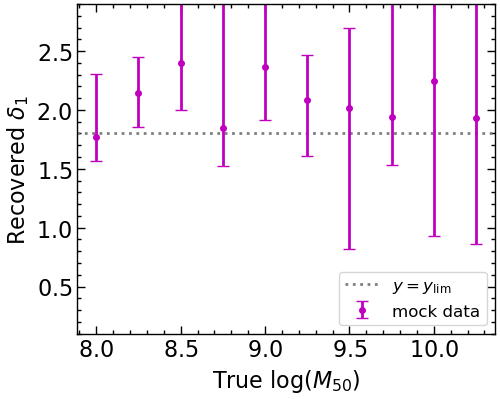

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5.2, 4.2))

#ax.plot([5, 11], [5, 11], lw=2, color='gray', zorder=-10, label=r'$y=x$')

beta_trues = np.full_like(beta_out_med, delta1_true)

ax.axhline(delta1_true, color='gray', linestyle='dotted', label=r'$y=y_{\rm{lim}}$')

ax.errorbar(x50_true, beta_out_med, yerr=np.abs(np.array([beta_out_hi-beta_out_med, beta_out_med-beta_out_lo])),
           color='m', marker='o', capsize=4, linestyle='none', markersize=4, label='mock data')

#ax.scatter(x50_true, x50_out_med, color='k')

ax.set_ylabel(r'Recovered $\delta_1$')
ax.set_xlabel(r'True $\log(M_{50})$')

#ax.text(6.2, 10.2, rf'$\beta = {beta_true}$', fontsize=14, color='m')

#ax.set_xlim(0, 1)
ax.set_ylim(0.1, 2.9)

ax.legend(loc=4, fontsize=12, frameon=True)

fig.tight_layout()
fig.savefig('betamock.pdf', dpi=300)

In [14]:
# problem with high censoring